In [2]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [7]:
DATA_DIR = "../../dataset/"
TRAIN_DIR = os.path.join(DATA_DIR, "train_images")
SEGM_DIR = os.path.join(DATA_DIR, "segmentations")

train_df = pd.read_csv(os.path.join(DATA_DIR, "train_df_with_slices.csv"))
print(train_df.shape)
train_df.head()

(2019, 10)


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,num_slices
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,243
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,406
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,385
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,501
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,199


## dcm 파일 읽기

File metadata

In [34]:
dcm = pydicom.dcmread(os.path.join(TRAIN_DIR, f"1.2.826.0.1.3680043.10921/101.dcm"))
dcm

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10921.1.101
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10921.1.101
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '182426.662201'
(0010, 0010) Patient's Name                      PN: '10921'
(0010, 0020) Patient ID                          LO: '10921'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

Rescale 하면 데이터의 평균이 0 에 가까워 지게 된다.
The Hounsfield unit (HU) is a relative quantitative measurement of radio density used by radiologists in the interpretation of computed tomography (CT) images.
HU 는 x-ray 를 쓴 값이랑 관계된대... 상대적 값이니까 평균이 0에 가깝게 되어있다.

In [9]:
# source: https://www.kaggle.com/code/allunia/rsna-csf-cervical-spine-fracture-eda/notebook
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit.
    """
    return dcm_ds.pixel_array * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept

In [10]:
def read_patient_dcm(patient_id):
    num_slices = train_df.loc[train_df["StudyInstanceUID"] == patient_id, "num_slices"].values[0]
    print(f"Number of slices for patient: {num_slices}")
    print(f"Fracture information for patient: ")
    print(f"{train_df[train_df['StudyInstanceUID'] == patient_id].iloc[:, 1:-1]}")
    patient_dir = os.path.join(TRAIN_DIR, patient_id)

    for i in range(num_slices):
        # dicom filenames start from 1
        ds = pydicom.dcmread(os.path.join(patient_dir, f"{i+1}.dcm"))
        if i == 0:
            pixel_spacing = ds.PixelSpacing
            slice_thickness = ds.SliceThickness
            axial_aspect = pixel_spacing[1] / pixel_spacing[0]
            sagittal_aspect = pixel_spacing[1] / slice_thickness
            coronal_aspect = slice_thickness / pixel_spacing[0]
            img_shape = list(ds.pixel_array.shape)
            img_shape.append(num_slices)
            img3d = np.zeros(img_shape)
        img2d = rescale_img_to_hu(ds)
        img3d[:, :, i] = img2d

    return img3d, axial_aspect, sagittal_aspect, coronal_aspect



In [17]:
patient_dcm, aa, sa, ca = read_patient_dcm("1.2.826.0.1.3680043.8693")
print(f"dcm shape {patient_dcm.shape} min {patient_dcm.min()} max {patient_dcm.max()}")
patient_dcm

Number of slices for patient: 69
Fracture information for patient: 
     patient_overall  C1  C2  C3  C4  C5  C6  C7
246                1   0   0   0   0   0   1   0
dcm shape (512, 512, 69) min -1024.0 max 3071.0


array([[[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ...,
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.]],

       [[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ...,
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.]],

       [[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ...,
        [-10

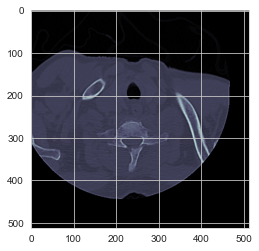

In [19]:
plt.imshow(patient_dcm[:, :, 47], cmap='bone')
plt.show()

(512, 512)


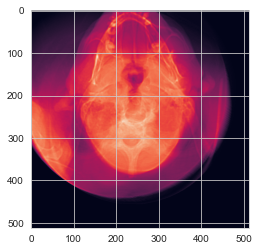

In [23]:
mean_dcm = patient_dcm.mean(axis=2)
print(mean_dcm.shape)
plt.imshow(mean_dcm)
plt.show()

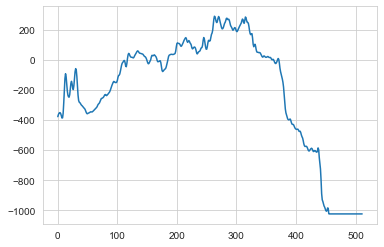

In [24]:
plt.plot(mean_dcm[:, 210])

여기서 마지막 0인 부위를 보면

In [29]:
np.where(abs(mean_dcm[:, 210]) < 1 )

(array([156, 360, 369]),)

### Number of slices per patient

In [7]:
def calc_num_slices_per_patient(train_df):
    num_slices = []
    for patient_id in train_df["StudyInstanceUID"]:
        slice_paths = glob.glob(f"{TRAIN_DIR}/{patient_id}/*")
        num_slices.append(len(slice_paths))
    train_df["num_slices"] = num_slices
    return train_df

In [8]:
train_df = calc_num_slices_per_patient(train_df)
train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,num_slices
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,0


### bbox dataframe

In [5]:
bboxes_df = pd.read_csv(os.path.join(DATA_DIR, "train_bounding_boxes.csv"))
print(bboxes_df.shape)
bboxes_df.head()

(7217, 6)


,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137


fracture 가 있는 위치 보여주기

Number of slices for patient: 272
Fracture information for patient: 
      patient_overall  C1  C2  C3  C4  C5  C6  C7
1253                1   0   0   0   1   0   0   0
Number of bounding boxes for patient: 16
image width 512 height 512
x 219 y 216 w 17 h 20
x 221 y 216 w 17 h 25
x 216 y 221 w 27 h 26
x 214 y 215 w 27 h 37
x 214 y 215 w 27 h 43
x 213 y 216 w 25 h 47
x 209 y 214 w 36 h 51
x 204 y 212 w 47 h 57
x 205 y 213 w 45 h 59
x 205 y 214 w 42 h 63
x 203 y 217 w 42 h 62
x 201 y 219 w 41 h 58
x 199 y 220 w 40 h 56
x 195 y 221 w 51 h 58
x 191 y 221 w 61 h 60
x 200 y 232 w 23 h 31


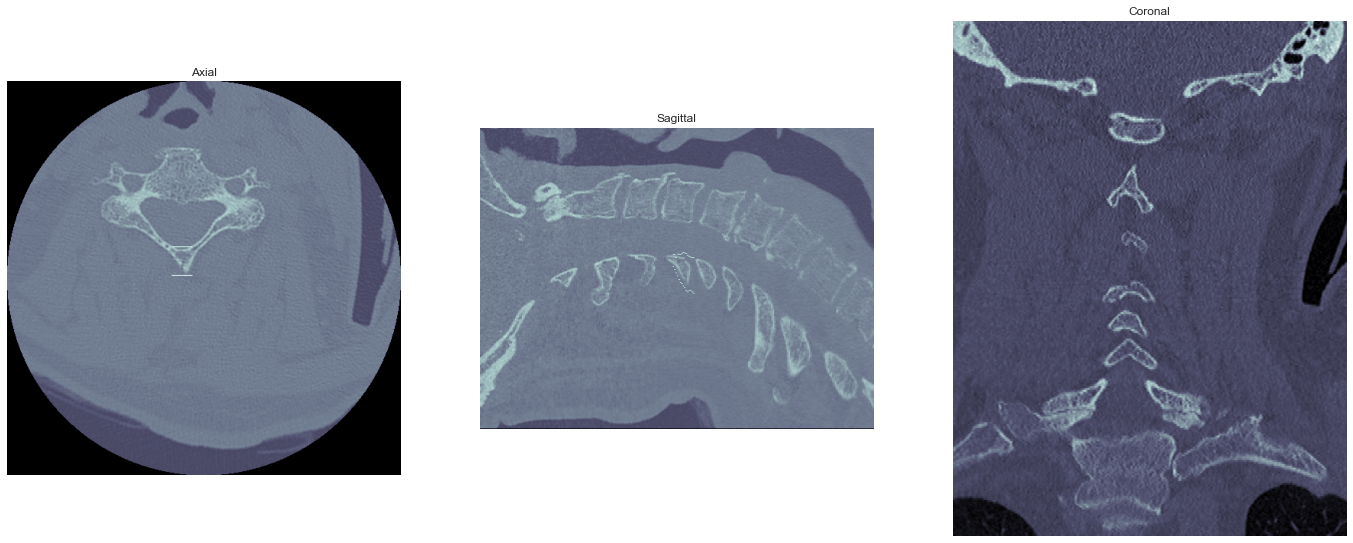

In [12]:
def plot_3d_for_patient_with_bbox(patient_id, sagittal_pos=None):
    num_slices = train_df.loc[train_df["StudyInstanceUID"] == patient_id, "num_slices"].values[0]
    print(f"Number of slices for patient: {num_slices}")
    print(f"Fracture information for patient: ")
    print(f"{train_df[train_df['StudyInstanceUID'] == patient_id].iloc[:, 1:-1]}")
    patient_dir = os.path.join(TRAIN_DIR, patient_id)

    bboxes_patient_df = bboxes_df[bboxes_df["StudyInstanceUID"] == patient_id]
    num_bboxes = bboxes_patient_df.shape[0]
    print(f"Number of bounding boxes for patient: {num_bboxes}")

    for i in range(num_slices):
        # dicom filenames start from 1
        ds = pydicom.dcmread(os.path.join(patient_dir, f"{i+1}.dcm"))
        if i == 0:
            pixel_spacing = ds.PixelSpacing
            slice_thickness = ds.SliceThickness
            axial_aspect = pixel_spacing[1] / pixel_spacing[0]
            sagittal_aspect = pixel_spacing[1] / slice_thickness
            coronal_aspect = slice_thickness / pixel_spacing[0]
            img_shape = list(ds.pixel_array.shape)
            img_shape.append(num_slices)
            img3d = np.zeros(img_shape)
        img2d = rescale_img_to_hu(ds)
        img3d[:, :, i] = img2d

    print(f"image width {img3d.shape[1]} height {img3d.shape[0]}")
    #     print(img3d[:, :, 0])
    for i in range(num_bboxes):
        bbox = bboxes_patient_df.iloc[i]
        num_slice = int(bbox["slice_number"])
        x = int(bbox["x"])
        y = int(bbox["y"])
        width = int(bbox["width"])
        height = int(bbox["height"])

        print(f"x {x} y {y} w {width} h {height}")


        #         img3d[y:y+height, x:x+width, num_slice] = 3024.0
        img3d[y, x:x+width, num_slice] = 3024.0
        img3d[y+height, x:x+width, num_slice] = 3024.0


    fig, axs = plt.subplots(1, 3, figsize=(24,15))

    axs[0].imshow(img3d[:, :, img_shape[2]//2], cmap="bone")
    axs[0].set_aspect(axial_aspect)
    axs[0].axis("off")
    axs[0].set_title("Axial")

    sagittal_pos = img_shape[1]//2 if sagittal_pos is None else sagittal_pos

    axs[1].imshow(img3d[:, sagittal_pos, :], cmap="bone")
    axs[1].set_aspect(sagittal_aspect)
    axs[1].axis("off")
    axs[1].set_title("Sagittal")

    axs[2].imshow(img3d[img_shape[0]//2, :, :].T, cmap="bone")
    axs[2].set_aspect(coronal_aspect)
    axs[2].axis("off")
    axs[2].set_title("Coronal")

plot_3d_for_patient_with_bbox("1.2.826.0.1.3680043.10051", sagittal_pos=225)

## segmentation

In [39]:
patient_id = "1.2.826.0.1.3680043.10921"
num_slice = 100

slice count 339
mask shape (512, 512, 339)


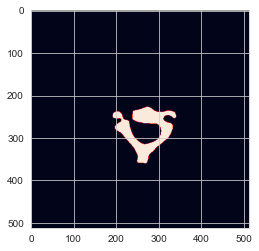

In [23]:

patient_dir = os.path.join(TRAIN_DIR, patient_id)

segm_path = os.path.join(SEGM_DIR, f"{patient_id}.nii")
segm_mask = nib.load(segm_path).get_fdata()

# flip in z axis
segm_mask = np.flip(segm_mask, axis=-1)
# rotate 90 degrees in xy
segm_mask = np.rot90(segm_mask, axes=(0, 1))

print(f"slice count {segm_mask.shape[2]}")
print(f"mask shape {segm_mask.shape}")

plt.imshow(segm_mask[:, :, num_slice])
plt.show()



dcm file looks like...

In [40]:
dcm = pydicom.dcmread(os.path.join(patient_dir, f"{num_slice+1}.dcm"))
dcm

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10921.1.101
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10921.1.101
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '182426.662201'
(0010, 0010) Patient's Name                      PN: '10921'
(0010, 0020) Patient ID                          LO: '10921'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

(512, 512)
min -3024.0 max 2295.0


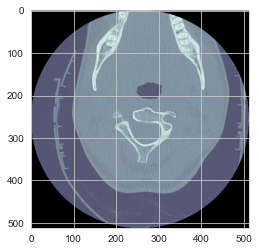

In [41]:
dcm_img = rescale_img_to_hu(dcm)
print(dcm_img.shape)
print(f"min {dcm_img.min()} max {dcm_img.max()}")
plt.imshow(dcm_img, cmap='bone')
plt.show()

<AxesSubplot:ylabel='Count'>

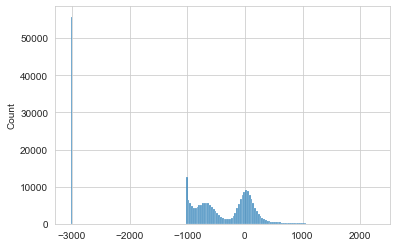

In [38]:
sns.histplot(dcm_img.flatten())

500 보다 작은 부분을 없앴더니....

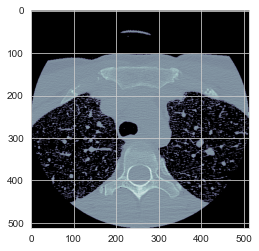

In [32]:
dcm_img[dcm_img < -500] = -3000
plt.imshow(dcm_img, cmap='bone')
plt.show()

500보다 큰 부분은???
여기서 이 중요한 흰색부분은 다 수치가 500보다 큰 부분이다. 만약에 이부분을 다 500으로 해버리면?

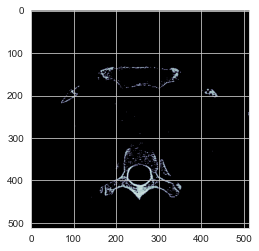

In [33]:
dcm_img[dcm_img < 500] = -3000
plt.imshow(dcm_img, cmap='bone')
plt.show()

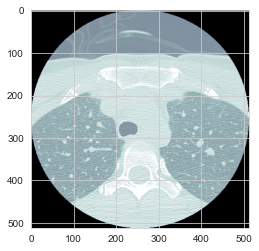

In [35]:
dcm_img[dcm_img > 500] = 500
plt.imshow(dcm_img, cmap='bone')
plt.show()

<AxesSubplot:ylabel='Count'>

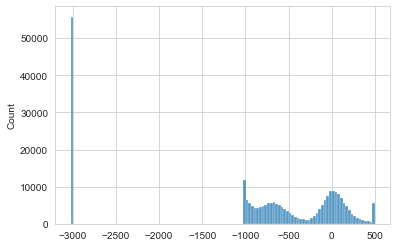

In [36]:
sns.histplot(dcm_img.flatten())

Image value 분포 보기

TypeError: _clip_dispatcher() missing 1 required positional argument: 'a_max'